# Application of Machine Learning Techniques to Trading

In [1]:
import numpy
import scipy
import sklearn
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

Կկառուցենք ՄԼ համակարգ հիմնաված որոշ X բացատրողների վրա որոնք կկարողանան կանխատեսել մեր Y-ը : Կսովորացնենք մոդելը պատմական տվյալների վրա: Վերջում, կօգտագործենք մեր մոդելը կանխատեսելու համար անհայտ Y-ը :

## Step 1: Setup your problem


Մենք կստեղծենք կանխատեսող մոդել, որը կկանխատեսի` 

$basis$ = Price of Stock - Price of Future

$basis_t=S_t−F_t$

$Y$ = future expected value of basis = $Average(basis_{(t+1)}, basis_{(t+2)}, basis_{(t+3)},basis_{(t+4)},basis_{(t+5)})$



$RMSE = \sqrt{\sum{(Y_{actual} - Y_{predicted})^2} / n} $

Our Objective: Create a model so that predicted value is as close as possible to Y

## Step 2: Collect Reliable Data

Մենք կօգտագործենք մեկ րոպե հաճախականության տվյալներ մի ամսվա համար:


Stock Bid Price, Ask Price, Bid Volume, Ask Volume 
Future Bid Price, Ask Price, Bid Volume, Ask Volume
$Stock VWAP = {Bid Price*Ask Volume +  Ask Price*Bid Volume}/(Ask Volume +  Bid Volume)$
Future VWAP

Դատան արդեն մաքրված է Dividend-ները, Split-երը, Roll-երը հաշվի առնելով

In [2]:
# Load the data
from urllib.request import urlopen
def getData(datasetId, instrumentId,fileName):
    if not os.path.isfile(fileName):
        url = 'https://raw.githubusercontent.com/Auquan/auquan-historical-data/master/qq2Data/%s/%s.csv' % (
            datasetId, instrumentId)
        response = urlopen(url)
        status = response.getcode()
        if status == 200:
            print('Downloading %s data to file: %s' % (instrumentId, fileName))
            with open(fileName, 'w+') as f:
                f.write(response.read().decode('utf8'))
        else:
            print('File not found. Please check settings!')

datasetId =  'trainingData1'
instrumentId = 'MQK'
fileName ='Python/School_PJ/'+instrumentId + '.csv'
getData(datasetId, instrumentId,fileName)
data = pd.read_csv(fileName, engine='python', index_col = 0, parse_dates=True)

In [89]:
# # Preparing our data
# data['Stock Price'] = data['stockTopBidPrice'] + data['stockTopAskPrice'] / 2.0
# data['Future Price'] = data['futureTopBidPrice'] + data['futureTopAskPrice'] / 2.0
# data['Y(Target)'] = data['basis'].shift(-5)
# del data['benchmark_score']
# del data['FairValue']

In [3]:
print(data.head(6))

                     stockVWAP  futureVWAP  basis  stockTopBidVol  \
2017-01-06 09:17:00    517.773     512.492  5.425              79   
2017-01-06 09:18:00    515.300     510.682  4.425              40   
2017-01-06 09:19:00    516.225     511.342  4.950              81   
2017-01-06 09:20:00    519.792     513.959  5.650             179   
2017-01-06 09:21:00    520.270     513.819  6.400              68   
2017-01-06 09:22:00    524.792     519.118  5.625            2299   

                     stockTopAskVol  stockTopBidPrice  stockTopAskPrice  \
2017-01-06 09:17:00              79            518.00            518.30   
2017-01-06 09:18:00              10            515.05            515.30   
2017-01-06 09:19:00            1496            516.20            516.45   
2017-01-06 09:20:00            1940            519.65            519.95   
2017-01-06 09:21:00              93            520.45            520.60   
2017-01-06 09:22:00            4924            524.60            5

In [4]:
#Available data

for i in range(len(data.columns)):
    print(data.columns[i])

stockVWAP
futureVWAP
basis
stockTopBidVol
stockTopAskVol
stockTopBidPrice
stockTopAskPrice
futureTopBidVol
futureTopAskVol
futureTopBidPrice
futureTopAskPrice
stockNextBidVol
stockNextAskVol
stockNextBidPrice
stockNextAskPrice
futureNextBidVol
futureNextAskVol
futureNextBidPrice
futureNextAskPrice
stockTotalBidVol
stockTotalAskVol
futureTotalBidVol
futureTotalAskVol
stockAverageBidPrice
stockAverageAskPrice
futureAverageBidPrice
futureAverageAskPrice
FairValue
benchmark_score


## Step 3: Split Data

Կբաժանենք training/validation/test մասերի:

In [5]:
# Training Data
datasetId =  'trainingData1'
instrumentId = 'MQK'
fileName = 'Python/'+ instrumentId + '_train.csv'
getData(datasetId, instrumentId,fileName)
training_data = pd.read_csv(fileName, engine='python', index_col = 0, parse_dates=True)

# Validation Data
datasetId =  'trainingData2'
instrumentId = 'MQK'
fileName = 'Python/'+ instrumentId + '_validation.csv'
getData(datasetId, instrumentId,fileName)
validation_data = pd.read_csv(fileName, engine='python', index_col = 0, parse_dates=True)

# Test Data
datasetId =  'trainingData3'
instrumentId = 'MQK'
fileName = 'Python/'+ instrumentId + '_test.csv'
getData(datasetId, instrumentId,fileName)
out_of_sample_test_data = pd.read_csv(fileName, engine='python', index_col = 0, parse_dates=True)

### Preparing Data

Կավելացնենք Y, որը հաջորդ 5 արժեքների միջինն է: 

In [6]:
def prepareData(data, period):
    data['Y(Target)'] = data['basis'].rolling(period).mean().shift(-period)
    if 'FairValue' in data.columns:
        del data['FairValue']
    data.dropna(inplace=True)

period = 5
prepareData(training_data, period)
prepareData(validation_data, period)
prepareData(out_of_sample_test_data, period)

## Step 4: Feature Engineering

Ստեղծենք մի քանի փոփոխականներ, որոնք կարող են ունենալ կանխատեսող ուժ մեր դատայի վրա:


*** Փոփոխականների ընտրման ոսկե կաննոնն է , որ կանխատեսող ուժը պետք է գա հենց փոփոխականից , այլ ոչ թե մոդելից: Փոփոխականի ընտրությունը շատ ավելի մեծ ազդեցություն ունի կանխատեսման վրա քան մոդելի ընտրությունը *

Մենք չպետք է պատահականորեն ընտրենք առանց ստուգելու դրանց կապը թիրախ հանդիսացող արժեքի հետ, քանի որ այն կարող է հանգեցնել overfit-ի : Դրանք կարող են միմյանց հետ կորելացված լինել, որը ցանկալի չէ:

Մենք կստեղծենք բացատրող փոփոխականների մեծ քանակ և կփորձենք քչացնել դրանք:


In [7]:
def difference(dataDf, period):
    return dataDf.sub(dataDf.shift(period), fill_value=0)

def ewm(dataDf, halflife):
    return dataDf.ewm(halflife=halflife,ignore_na=False,min_periods=0,adjust=True).mean()

def rsi(data, period):
    data_upside = data.sub(data.shift(1), fill_value=0)
    data_downside = data_upside.copy()
    data_downside[data_upside > 0] = 0
    data_upside[data_upside < 0] = 0
    avg_upside = data_upside.rolling(period).mean()
    avg_downside = - data_downside.rolling(period).mean()
    rsi = 100 - (100 * avg_downside / (avg_downside + avg_upside))
    rsi[avg_downside == 0] = 100
    rsi[(avg_downside == 0) & (avg_upside == 0)] = 0

    return rsi

In [9]:
def create_features(data):
    basis_X = pd.DataFrame(index = data.index, columns =  [ 'emabasis3','emabasis5','emabasis2','emabasis7','emabasis10',\
                                                             'emabasis4','rsi15','rsi10','rsi5','mom1','mom10',\
                                                             'mom3','mom5'])
    
    basis_X['mom1'] = difference(data['basis'],2)
    basis_X['mom3'] = difference(data['basis'],4)
    basis_X['mom5'] = difference(data['basis'],6)
    basis_X['mom10'] = difference(data['basis'],11)

    basis_X['rsi15'] = rsi(data['basis'],15)
    basis_X['rsi10'] = rsi(data['basis'],10)
    basis_X['rsi5'] = rsi(data['basis'],5)
    
    basis_X['emabasis2'] = ewm(data['basis'],2)
    basis_X['emabasis3'] = ewm(data['basis'],3)
    basis_X['emabasis4'] = ewm(data['basis'],4)
    basis_X['emabasis5'] = ewm(data['basis'],5)
    basis_X['emabasis7'] = ewm(data['basis'],7)
    basis_X['emabasis10'] = ewm(data['basis'],10)

    basis_X['basis'] = data['basis']
    basis_X['vwapbasis'] = data['stockVWAP']-data['futureVWAP']
    
    basis_X['swidth'] = data['stockTopAskPrice']-data['stockTopBidPrice']
    basis_X['fwidth'] = data['futureTopAskPrice']-data['futureTopBidPrice']
    
    basis_X['btopask'] = data['stockTopAskPrice']-data['futureTopAskPrice']
    basis_X['btopbid'] =data['stockTopBidPrice']-data['futureTopBidPrice']
    basis_X['bavgask'] = data['stockAverageAskPrice']-data['futureAverageAskPrice']
    basis_X['bavgbid'] = data['stockAverageBidPrice']-data['futureAverageBidPrice']
    basis_X['bnextask'] = data['stockNextAskPrice']-data['futureNextAskPrice']
    basis_X['bnextbid'] = data['stockNextBidPrice']-data['futureNextBidPrice']
    basis_X['topaskvolratio'] = data['stockTopAskVol']/data['futureTopAskVol']
    basis_X['topbidvolratio'] = data['stockTopBidVol']/data['futureTopBidVol']
    basis_X['totalaskvolratio'] = data['stockTotalAskVol']/data['futureTotalAskVol']
    basis_X['totalbidvolratio'] = data['stockTotalBidVol']/data['futureTotalBidVol']
    basis_X['nextbidvolratio'] = data['stockNextBidVol']/data['futureNextBidVol']
    basis_X['nextaskvolratio'] = data['stockNextAskVol']-data['futureNextAskVol']
    
    basis_X['emabasisdi4'] = basis_X['emabasis7'] - basis_X['emabasis5'] + basis_X['emabasis2']
    basis_X['emabasisdi7'] = basis_X['emabasis7'] - basis_X['emabasis5']+ basis_X['emabasis3']
    basis_X['emabasisdi1'] = basis_X['emabasis10'] - basis_X['emabasis5'] + basis_X['emabasis3']
    basis_X['emabasisdi3'] = basis_X['emabasis10'] - basis_X['emabasis3']+ basis_X['emabasis5']
    basis_X['emabasisdi5'] = basis_X['emabasis7']- basis_X['emabasis5'] + data['basis']
    basis_X['emabasisdi'] = basis_X['emabasis5'] - basis_X['emabasis3'] + data['basis']
    basis_X['emabasisdi6'] = basis_X['emabasis7'] - basis_X['emabasis3']+ data['basis']
    basis_X['emabasisdi2'] = basis_X['emabasis10'] - basis_X['emabasis5']+ data['basis']
    basis_X['emabasisdi3'] = basis_X['emabasis10'] - basis_X['emabasis3']+ basis_X['emabasis5']
    
    basis_X = basis_X.fillna(0)
    
    basis_y = data['Y(Target)']
    basis_y.dropna(inplace=True)
    
    print("Any null data in y: %s, X: %s"%(basis_y.isnull().values.any(), basis_X.isnull().values.any()))
    print("Length y: %s, X: %s"%(len(basis_y.index), len(basis_X.index)))
    
    return basis_X, basis_y

In [10]:
basis_X_train, basis_y_train = create_features(training_data)
basis_X_test, basis_y_test = create_features(validation_data)

Any null data in y: False, X: False
Length y: 8737, X: 8737
Any null data in y: False, X: False
Length y: 6499, X: 6499


## Step 5: Model Selection

Սկսենք գծային ռեգրեսիայով , չնոռմալիզացված փոփոխականներով:

In [11]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

def linear_regression(basis_X_train, basis_y_train, basis_X_test,basis_y_test):
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(basis_X_train, basis_y_train)
    # Make predictions using the testing set
    basis_y_pred = regr.predict(basis_X_test)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(basis_y_test, basis_y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

    # Plot outputs
    plt.scatter(basis_y_pred, basis_y_test,  color='black')
    plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)

    plt.xlabel('Y(actual)')
    plt.ylabel('Y(Predicted)')

    plt.show()
    
    return regr, basis_y_pred

## Step 6: Train, Validate and Optimize (repeat steps 4-6)

Հիմա, փորձենք կրկնել տարբեր մոդելների , մոդելների պարամետրերի և փոփոխականների միջև

Coefficients: 
 [ 2.12135878e+08 -8.07854245e+07 -2.60725589e+07 -2.86403102e+07
 -1.10610840e+07 -5.65987619e+01 -1.04282796e-03 -6.17578626e-04
 -7.99447298e-05  4.34963163e-02  1.16113489e-02  5.75578082e-02
 -3.05728987e-02 -3.65410869e+07  8.40893202e-02  5.31984413e-03
 -7.77755177e-03 -3.65410869e+07 -3.65410869e+07  6.47519287e-02
  5.72136296e-02  2.80798040e-03  1.58256376e-02 -7.67695799e-03
 -7.69951381e-04 -3.87397404e-02  3.12804725e-02  3.40926647e-03
 -1.30385160e-06  2.60725552e+07 -6.95268302e+07 -5.19476041e+07
  2.98254360e+07  1.56040272e+07  4.34543316e+06  5.64905473e+07
  3.31832533e+07]
Mean squared error: 0.02
Variance score: 0.96


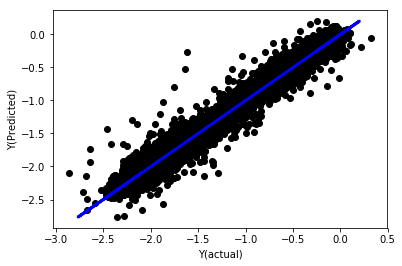

In [12]:
_, basis_y_pred = linear_regression(basis_X_train, basis_y_train, basis_X_test,basis_y_test)

Այս պահին չենք կարող ասել, թե փոփոխականներից որն է լավը , քանի որ նրանք ունեն տարբեր մասշտաբներ:
Փորձենք նորմալիզացնել և հասնել ստացիոնարության:

In [19]:
def normalize(basis_X, basis_y, period):
    basis_X_norm = (basis_X - basis_X.rolling(period).mean())/basis_X.rolling(period).std()
    basis_X_norm.dropna(inplace=True)
    basis_y_norm = (basis_y - basis_X['basis'].rolling(period).mean())/basis_X['basis'].rolling(period).std()
    basis_y_norm = basis_y_norm[basis_X_norm.index]
    
    return basis_X_norm, basis_y_norm

Coefficients: 
 [-3.62562336e+00 -9.15274240e+00  1.44465722e+00  8.87792905e+00
 -5.55687316e+00  1.98323173e+01 -3.52677595e-03 -1.46185137e-02
 -2.28603171e-02  8.89158364e-03  1.96775578e-02 -1.09431839e-03
 -3.32224637e-03 -7.91656252e+00  4.98693313e-02  6.53834026e-03
  1.12615956e-02  2.08691443e+00  2.03221946e+00  9.75083631e-02
  6.10888994e-02 -3.13066921e-02  4.78554884e-02  5.84281791e-04
  1.12986615e-02 -2.19490620e-02  2.31187541e-02  5.69928897e-03
 -5.78663706e-03  3.02309761e+00 -2.45138755e+01  1.00726718e+01
  2.00852825e-02  1.53648992e+01 -9.16940626e+00  4.29745408e+00
 -6.36285008e+00]
Mean squared error: 0.28
Variance score: 0.77


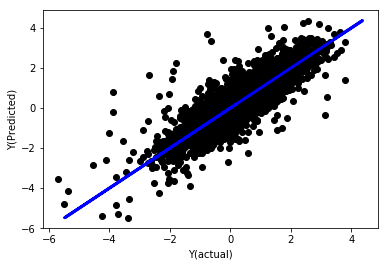

In [20]:
norm_period = 375
basis_X_norm_test, basis_y_norm_test = normalize(basis_X_test,basis_y_test, norm_period)
basis_X_norm_train, basis_y_norm_train = normalize(basis_X_train, basis_y_train, norm_period)

regr_norm, basis_y_pred = linear_regression(basis_X_norm_train, basis_y_norm_train, basis_X_norm_test, basis_y_norm_test)

Արդյունքը այնքան էլ լավը չէ: Վերադառնանք չնորմալիզացված դատային

Mean squared error: 0.05
Variance score: 0.90


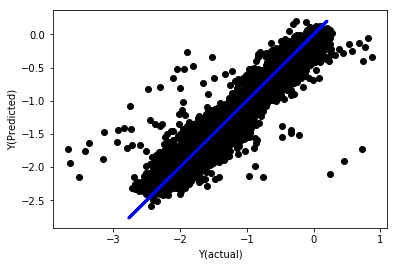

In [21]:
basis_y_pred = basis_y_pred * basis_X_test['basis'].rolling(period).std()[basis_y_norm_test.index] + basis_X_test['basis'].rolling(period).mean()[basis_y_norm_test.index]

print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test[basis_y_norm_test.index], basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test[basis_y_norm_test.index], basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test[basis_y_norm_test.index],  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)

plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()


Մոդելը ավելի լավը չէ քան նախորդը, բայց ոչ ավելի վատը: Հիմա մենք կարող ենք նայել փոփխականներին, հասկանալու համար թե թրն է ավելի կարևոր:


In [22]:
for i in range(len(basis_X_train.columns)):
    print('%.4f, %s'%(regr_norm.coef_[i], basis_X_train.columns[i]))

-3.6256, emabasis3
-9.1527, emabasis5
1.4447, emabasis2
8.8779, emabasis7
-5.5569, emabasis10
19.8323, emabasis4
-0.0035, rsi15
-0.0146, rsi10
-0.0229, rsi5
0.0089, mom1
0.0197, mom10
-0.0011, mom3
-0.0033, mom5
-7.9166, basis
0.0499, vwapbasis
0.0065, swidth
0.0113, fwidth
2.0869, btopask
2.0322, btopbid
0.0975, bavgask
0.0611, bavgbid
-0.0313, bnextask
0.0479, bnextbid
0.0006, topaskvolratio
0.0113, topbidvolratio
-0.0219, totalaskvolratio
0.0231, totalbidvolratio
0.0057, nextbidvolratio
-0.0058, nextaskvolratio
3.0231, emabasisdi4
-24.5139, emabasisdi7
10.0727, emabasisdi1
0.0201, emabasisdi3
15.3649, emabasisdi5
-9.1694, emabasisdi
4.2975, emabasisdi6
-6.3629, emabasisdi2


Կարող ենք տեսնել որ , որոշ փոփոխականներ ունեն ավելի ավելի մեծ կարևորություն:
Նայենք նրանք կորելացիաներին

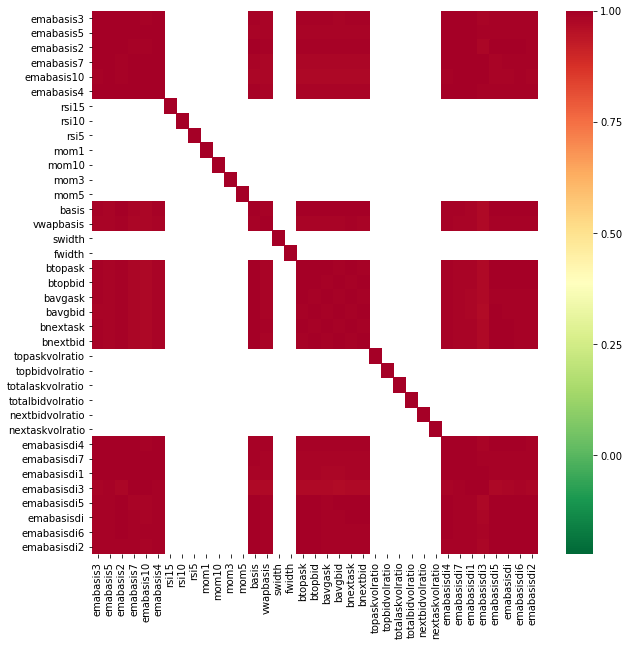

In [23]:
import seaborn

c = basis_X_train.corr()
plt.figure(figsize=(10,10))
seaborn.heatmap(c, cmap='RdYlGn_r', mask = (np.abs(c) <= 0.8))
plt.show()


Կարմիրները ցույց են տալի կորելացված փոփոխականները: Փոփոխենք և շարունակենք

In [24]:
def create_features_again(data):
    basis_X = pd.DataFrame(index = data.index, columns =  [])
    
#     basis_X['mom1'] = difference(data['basis'],2)
#     basis_X['mom3'] = difference(data['basis'],4)
#     basis_X['mom5'] = difference(data['basis'],6)
    basis_X['mom10'] = difference(data['basis'],11)

#     basis_X['rsi15'] = rsi(data['basis'],15)
#     basis_X['rsi10'] = rsi(data['basis'],10)
#     basis_X['rsi5'] = rsi(data['basis'],5)
    
    basis_X['emabasis2'] = ewm(data['basis'],2)
#     basis_X['emabasis3'] = ewm(data['basis'],3)
#     basis_X['emabasis4'] = ewm(data['basis'],4)
    basis_X['emabasis5'] = ewm(data['basis'],5)
#     basis_X['emabasis8'] = ewm(data['basis'],8)
    basis_X['emabasis10'] = ewm(data['basis'],10)

    basis_X['basis'] = data['basis']
#     basis_X['vwapbasis'] = data['stockVWAP']-data['futureVWAP']
    
#     basis_X['swidth'] = data['stockTopAskPrice']-data['stockTopBidPrice'] + (data['futureTopAskPrice']-data['futureTopBidPrice'])
    
#     basis_X['btopask'] = data['stockTopAskPrice']-data['futureTopAskPrice']
#     basis_X['btopbid'] =data['stockTopBidPrice']-data['futureTopBidPrice']
#     basis_X['bavgask'] = data['stockAverageAskPrice']-data['futureAverageAskPrice']
#     basis_X['bavgbid'] = data['stockAverageBidPrice']-data['futureAverageBidPrice']
#     basis_X['bnextask'] = data['stockNextAskPrice']-data['futureNextAskPrice']
#     basis_X['bnextbid'] = data['stockNextBidPrice']-data['futureNextBidPrice']
#     basis_X['topaskvolratio'] = data['stockTopAskVol']-data['futureTopAskVol']
#     basis_X['topbidvolratio'] = data['stockTopBidVol']-data['futureTopBidVol']
    basis_X['totalaskvolratio'] = (data['stockTotalAskVol']-data['futureTotalAskVol'])/100000
    basis_X['totalbidvolratio'] = (data['stockTotalBidVol']-data['futureTotalBidVol'])/100000
#     basis_X['nextbidvolratio'] = data['stockNextBidVol']-data['futureNextBidVol']
#     basis_X['nextaskvolratio'] = data['stockNextAskVol']-data['futureNextAskVol']
    
    basis_X = basis_X.fillna(0)
    
    basis_y = data['Y(Target)']
    basis_y.dropna(inplace=True)
    
    print("Any null data in y: %s, X: %s"%(basis_y.isnull().values.any(), basis_X.isnull().values.any()))
    print("Length y: %s, X: %s"%(len(basis_y.index), len(basis_X.index)))
    
    return basis_X, basis_y

Any null data in y: False, X: False
Length y: 6499, X: 6499
Any null data in y: False, X: False
Length y: 8737, X: 8737
Coefficients: 
 [-0.0067528   0.52879292 -0.37816556  0.2323171   0.53062944 -0.01874965
  0.028642  ]
Mean squared error: 0.28
Variance score: 0.77


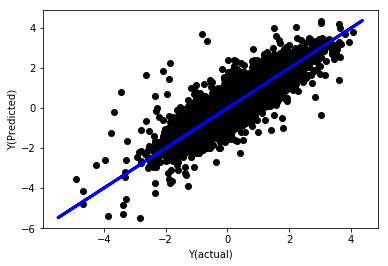

In [25]:
basis_X_test, basis_y_test = create_features_again(validation_data)
basis_X_train, basis_y_train = create_features_again(training_data)
norm_period = 375
basis_X_norm_test, basis_y_norm_test = normalize(basis_X_test,basis_y_test, norm_period)
basis_X_norm_train, basis_y_norm_train = normalize(basis_X_train, basis_y_train, norm_period)

regr_norm, basis_y_pred = linear_regression(basis_X_norm_train, basis_y_norm_train, basis_X_norm_test, basis_y_norm_test)


Mean squared error: 0.06
Variance score: 0.87


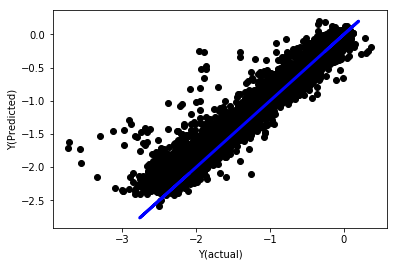

-0.006752804064526868 mom10
0.5287929217358888 emabasis2
-0.37816555527187784 emabasis5
0.23231709523847993 emabasis10
0.5306294374732963 basis
-0.018749648783602302 totalaskvolratio
0.028641995632552618 totalbidvolratio


In [27]:
basis_y_pred = basis_y_pred * basis_X_test['basis'].rolling(period).std()[basis_y_norm_test.index] + basis_X_test['basis'].rolling(period).mean()[basis_y_norm_test.index]

print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test[basis_y_norm_test.index], basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test[basis_y_norm_test.index], basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test[basis_y_norm_test.index],  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)

plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

for i in range(len(basis_X_train.columns)):
    print(regr_norm.coef_[i], basis_X_train.columns[i])

ՄԵր մոդելի արդյունավետությունը չփոխվեց, որը նշանակում է մեզ ընդամենը մի քանի փոփոխական էր պետք նույն արդյունքի համար:

Կարող ենք փորձել նաև ավելի բարդ մոդելներ ՝ տեսնելու, թե արդյոք մոդելի փոփոխությունը կարող է բարելավել կատարումը

### K Nearest Neighbours

Mean squared error: 0.02
Variance score: 0.95


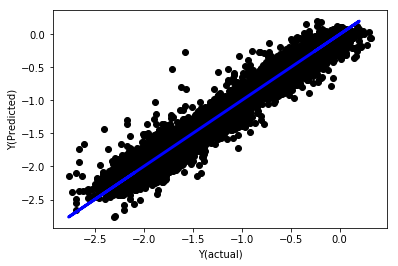

In [30]:
from sklearn import neighbors
n_neighbors = 5

model = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
model.fit(basis_X_train, basis_y_train)
basis_y_pred = model.predict(basis_X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test, basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test,  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)

plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

basis_y_knn = basis_y_pred.copy()

### SVR

Mean squared error: 0.02
Variance score: 0.95


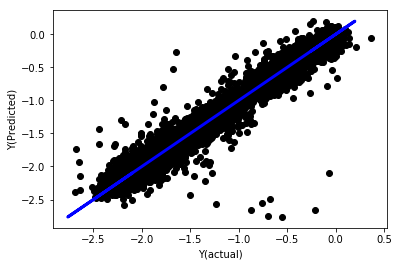

In [31]:
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=1e3, gamma=0.1)

model.fit(basis_X_train, basis_y_train)
basis_y_pred = model.predict(basis_X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test, basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test,  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)


plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

basis_y_svr = basis_y_pred.copy()

### Decision Trees

Mean squared error: 0.02
Variance score: 0.95


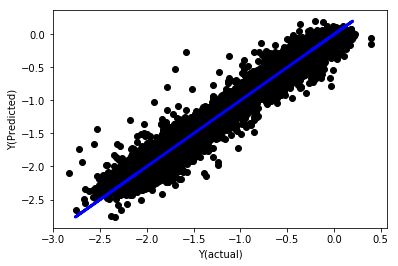

In [33]:
from sklearn import ensemble

model=ensemble.ExtraTreesRegressor()
model.fit(basis_X_train, basis_y_train)
basis_y_pred = model.predict(basis_X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test, basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test,  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)


plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

basis_y_trees = basis_y_pred.copy()

### Ensemble Method

We could try averaging predictions from all of the above methods to make our final prediction. Some models may work well in prediction certain scenarios and other in prediction other scenarios. Or a model may be extremely overfitting in a certain scenario. Aggregating predictions from different models can reduce error and overfitting, with errors from different models likely getting cancelled out or reduced. 

One simple way is to simply average the predictions. Other common ensemble methods are Bagging and Boosting.


In [34]:
basis_y_pred_ensemble = (basis_y_trees + basis_y_svr + +basis_y_knn + basis_y_regr)/4

Mean squared error: 0.02
Variance score: 0.95


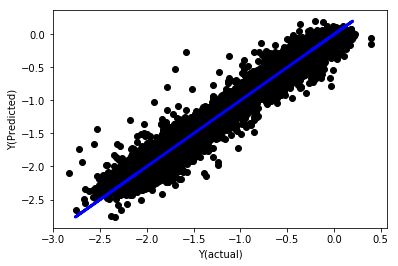

In [35]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test, basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test,  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)


plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

Note thatI have only mentioned a few common models here. You should try feature egineering with each of them and also play with model parameters to further optimize.

You loop over this stage multiple times till you finally have a model that you’re happy with. Only when you have a model who’s performance you like, proceed to the next step.

## Step 7: Backtest on Test Data

Finally I backtest performance of our final, optimized model from last step on that Test Data that we had kept aside at the start and did not touch yet.
This provides you with realistic expectation of how your model is expected to perform on new and unseen data when you start trading live. Hence, it is necessary to ensure you have a clean dataset that you haven’t used to train or validate your model.

We're going to choose our linear regression model as our final model of choice. For this purpose, I'm going to use Auquan’s [python based free and open source toolbox](https://bitbucket.org/auquan/auquantoolbox). You can install it via pip: 

`pip install -U auquan_toolbox`

In [39]:
import backtester
from backtester.features.feature import Feature
from backtester.trading_system import TradingSystem
from backtester.sample_scripts.fair_value_params import FairValueTradingParams

In [41]:
class Problem1Solver():

    def getTrainingDataSet(self):
        return "trainingData1"

    def getSymbolsToTrade(self):
        return ['MQK']

    def getCustomFeatures(self):
        return {'my_custom_feature': MyCustomFeature}

    def getFeatureConfigDicts(self):
                            
        expma5dic = {'featureKey': 'emabasis5',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 5,
                              'featureName': 'basis'}}
        expma10dic = {'featureKey': 'emabasis10',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 10,
                              'featureName': 'basis'}}                     
        expma2dic = {'featureKey': 'emabasis3',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 3,
                              'featureName': 'basis'}}
        mom10dic = {'featureKey': 'mom10',
                 'featureId': 'difference',
                 'params': {'period': 11,
                              'featureName': 'basis'}}
        
        return [expma5dic,expma2dic,expma10dic,mom10dic]    
    
    def getFairValue(self, updateNum, time, instrumentManager):
        # holder for all the instrument features
        lbInstF = instrumentManager.getlookbackInstrumentFeatures()
        mom10 = lbInstF.getFeatureDf('mom10').iloc[-1]
        emabasis2 = lbInstF.getFeatureDf('emabasis2').iloc[-1]
        emabasis5 = lbInstF.getFeatureDf('emabasis5').iloc[-1]
        emabasis10 = lbInstF.getFeatureDf('emabasis10').iloc[-1] 
        basis = lbInstF.getFeatureDf('basis').iloc[-1]
        totalaskvol = lbInstF.getFeatureDf('stockTotalAskVol').iloc[-1] - lbInstF.getFeatureDf('futureTotalAskVol').iloc[-1]
        totalbidvol = lbInstF.getFeatureDf('stockTotalBidVol').iloc[-1] - lbInstF.getFeatureDf('futureTotalBidVol').iloc[-1]
        
        coeff = [ 0.03249183, 0.49675487, -0.22289464, 0.2025182, 0.5080227, -0.21557005, 0.17128488]
        newdf['MQK'] = coeff[0] * mom10['MQK'] + coeff[1] * emabasis2['MQK'] +\
                      coeff[2] * emabasis5['MQK'] + coeff[3] * emabasis10['MQK'] +\
                      coeff[4] * basis['MQK'] + coeff[5] * totalaskvol['MQK']+\
                      coeff[6] * totalbidvol['MQK']
                    
        newdf.fillna(emabasis5,inplace=True)
        return newdf 

class MyCustomFeature(Feature):
    ''''
    Custom Feature to implement for instrument. This function would return the value of the feature you want to implement.
    '''
    @classmethod
    def computeForInstrument(cls, updateNum, time, featureParams, featureKey, instrumentManager):
        # Custom parameter which can be used as input to computation of this feature
        instrumentLookbackData = instrumentManager.getlbInstF()
        data = instrumentLookbackData.getFeatureDf(featureKey)
        if len(data.index) >= 1:
            prev_ema = data.iloc[-1]
        else:
            prev_ema = instrumentLookbackData.getFeatureDf(featureParams['featureName']).iloc[-1]
        halflife = featureParams['period']
        alpha = 2/(halflife+1)
        avg = instrumentLookbackData.getFeatureDf(featureParams['featureName']).iloc[-1] * alpha + prev_ema * (1 - alpha)
        return avg


In [51]:
problem1Solver = Problem1Solver()
tsParams = FairValueTradingParams(problem1Solver)
tsParams
tradingSystem = TradingSystem(tsParams)
# tradingSystem.startTrading(onlyAnalyze=False, shouldPlot=True, makeInstrumentCsvs=False)

Processing data for stock: MQK


ValueError: unconverted data remains:  09:17:00

It is important to remember that if you don’t like the results of your backtest on test data, discard the model and start again. DO NOT go back and re-optimize your model, this will lead to over fitting! (Also recommend to create a new test data set, since this one is now tainted; in discarding a model, we implicitly know something about the dataset).